# AirBnb Data Project
This project consists of the following:
1) Downloading listing data
2) Cleaning the raw data
3) Inserting the cleaned data into a SQL database
4) Exploring the data via SQL

## Data Cleaning

In [61]:
import pandas as pd

In [62]:
#importing in the air bnb data, which was scrapped for nyc march 2025
datapath = 'data/'
dirty_data = 'nyc_airbnb_listings_march.csv'

#analyzing the different columns
dirty_df = pd.read_csv(datapath+dirty_data)
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37434 non-null  float64
 1   listing_url                                   37434 non-null  object 
 2   scrape_id                                     37434 non-null  float64
 3   last_scraped                                  37434 non-null  object 
 4   source                                        37434 non-null  object 
 5   name                                          37432 non-null  object 
 6   description                                   36441 non-null  object 
 7   neighborhood_overview                         20224 non-null  object 
 8   picture_url                                   37433 non-null  object 
 9   host_id                                       37434 non-null 

In [63]:
#deciding which columns to keep, based on a subjective analysis of what information is useful
kept_indices= [0,9,18,26,28,29,30,31,33,35,37,38,40,56,65]

#illustrating which columns where kept vs dropped
all_columns = dirty_df.columns.tolist()
kept_columns = [all_columns[i] for i in kept_indices]
dropped_columns = [col for col in all_columns if col not in kept_columns]

comparison_df = pd.DataFrame({
    'Kept Columns' : pd.Series(kept_columns),
    'Dropped Columns' : pd.Series(dropped_columns)
})

comparison_df.fillna('', inplace=True)
comparison_df

,Kept Columns,Dropped Columns
0,id,listing_url
1,host_id,scrape_id
2,host_is_superhost,last_scraped
3,host_identity_verified,source
4,neighbourhood_cleansed,name
...,...,...
59,,calculated_host_listings_count
60,,calculated_host_listings_count_entire_homes
61,,calculated_host_listings_count_private_rooms
62,,calculated_host_listings_count_shared_rooms


In [64]:
#filter the df
df_filtered  = dirty_df.iloc[:,kept_indices]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            37434 non-null  float64
 1   host_id                       37434 non-null  int64  
 2   host_is_superhost             36994 non-null  object 
 3   host_identity_verified        37396 non-null  object 
 4   neighbourhood_cleansed        37434 non-null  object 
 5   neighbourhood_group_cleansed  37434 non-null  object 
 6   latitude                      37434 non-null  float64
 7   longitude                     37434 non-null  float64
 8   room_type                     37434 non-null  object 
 9   bathrooms                     22503 non-null  float64
 10  bedrooms                      31523 non-null  float64
 11  beds                          22352 non-null  float64
 12  price                         22308 non-null  object 
 13  n

In [65]:
df_filtered.head()

,id,host_id,host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,36121.0,62165,f,t,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room,1.0,1.0,1.0,$200.00,9,4.88
1,36647.0,157798,f,t,East Harlem,Manhattan,40.792454,-73.940742,Private room,1.0,1.0,1.0,$82.00,102,4.77
2,38663.0,165789,f,t,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room,2.5,5.0,5.0,$765.00,43,4.70
3,38833.0,166532,t,t,Harlem,Manhattan,40.818058,-73.946671,Entire home/apt,1.0,1.0,1.0,$139.00,241,4.85
4,39282.0,168525,t,t,Williamsburg,Brooklyn,40.710651,-73.950874,Private room,1.0,1.0,1.0,$130.00,274,4.82


In [66]:
#clean the dataframe
df_filtered = df_filtered.dropna(subset=['price','bathrooms','bedrooms','beds'])

df_filtered['host_is_superhost'] = df_filtered['host_is_superhost'].fillna('f')
df_filtered['review_scores_rating'] = df_filtered['review_scores_rating'] .fillna('unrated')

df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)

df_cleaned = df_filtered.copy()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22175 entries, 0 to 37433
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            22175 non-null  float64
 1   host_id                       22175 non-null  int64  
 2   host_is_superhost             22175 non-null  object 
 3   host_identity_verified        22155 non-null  object 
 4   neighbourhood_cleansed        22175 non-null  object 
 5   neighbourhood_group_cleansed  22175 non-null  object 
 6   latitude                      22175 non-null  float64
 7   longitude                     22175 non-null  float64
 8   room_type                     22175 non-null  object 
 9   bathrooms                     22175 non-null  float64
 10  bedrooms                      22175 non-null  float64
 11  beds                          22175 non-null  float64
 12  price                         22175 non-null  float64
 13  number

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\erict\AppData\Local\Temp\ipykernel_24880\3180315373.py:7: SyntaxWarning: invalid escape sequence '\$'
  df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)


## SQL Database

In [67]:
#establish connection
import sqlite3
conn = sqlite3.connect('db/airbnb.db')

In [68]:
#write dataframe to the database
def write_df(df,name):
    df.to_sql(name, conn, if_exists='replace', index=False)

In [69]:
#display query function
def run_query(query):
    return pd.read_sql(query, conn)

In [70]:
#publish our "main" dataframe
write_df(df_cleaned,"listings")

## Data Exploration

In [102]:
#lets look for some insights int the data

neighborhood_pricing = run_query(
"""
SELECT neighbourhood_group_cleansed, neighbourhood_cleansed, AVG(price) AS avg_price,
RANK() OVER (PARTITION BY neighbourhood_group_cleansed ORDER BY avg_price DESC) AS rank
FROM listings
GROUP BY neighbourhood_group_cleansed, neighbourhood_cleansed;
""")

write_df(neighborhood_pricing,'neighborhood_pricing')
neighborhood_pricing

DatabaseError: Execution failed on sql '
SELECT neighbourhood_group_cleansed, neighbourhood_cleansed, AVG(price) AS avg_price,
RANK() OVER (PARTITION BY neighbourhood_group_cleansed ORDER BY avg_price DESC) AS rank
FROM listings
GROUP BY neighbourhood_group_cleansed, neighbourhood_cleansed;
': no such column: avg_price

In [ ]:
borough_pricing = run_query(
"""
SELECT neighbourhood_group_cleansed, AVG(price) AS avg_price
FROM listings
GROUP BY neighbourhood_group_cleansed
ORDER BY avg_price DESC
""")

write_df(borough_pricing,'borough_pricing')
borough_pricing

,neighbourhood_group_cleansed,avg_price
0,Manhattan,287.054973
1,Brooklyn,169.737416
2,Staten Island,128.609524
3,Queens,126.266804
4,Bronx,121.831683


In [ ]:
most_expensive_neighborhood_by_borough = run_query(
"""
SELECT neighbourhood_group_cleansed, neighbourhood_cleansed
FROM listings 

""")

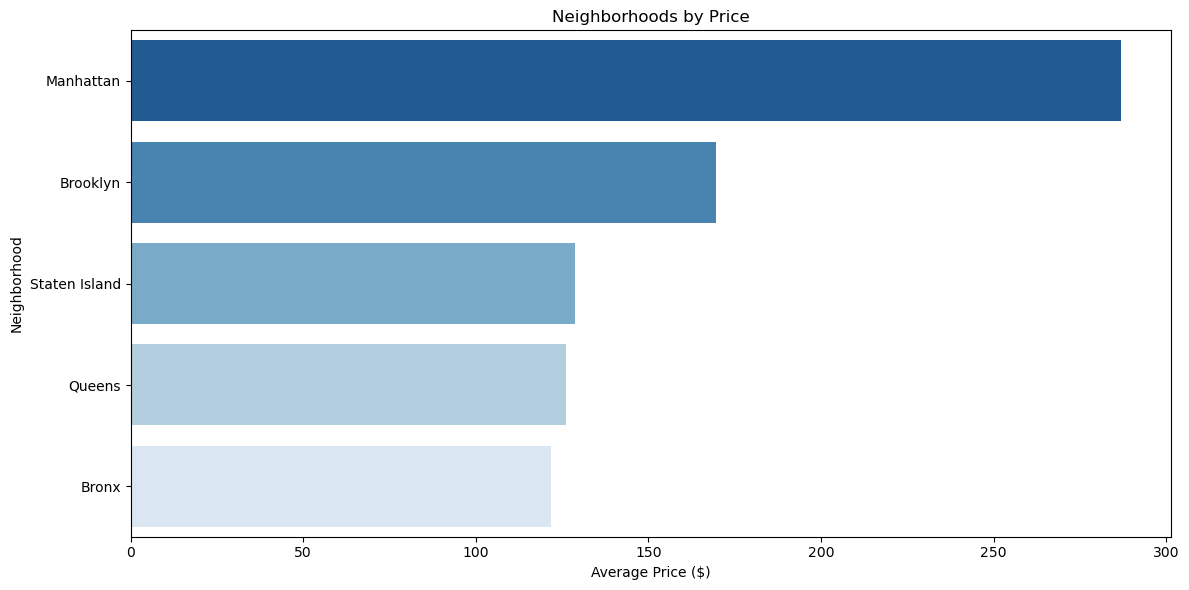

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=borough_pricing, x='avg_price', y='neighbourhood_group_cleansed', palette='Blues_r', hue='neighbourhood_group_cleansed')
plt.title("Neighborhoods by Price")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()